Logistic Regression

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.59      0.53       128
           1       0.66      0.57      0.61       182

    accuracy                           0.57       310
   macro avg       0.57      0.58      0.57       310
weighted avg       0.59      0.57      0.58       310



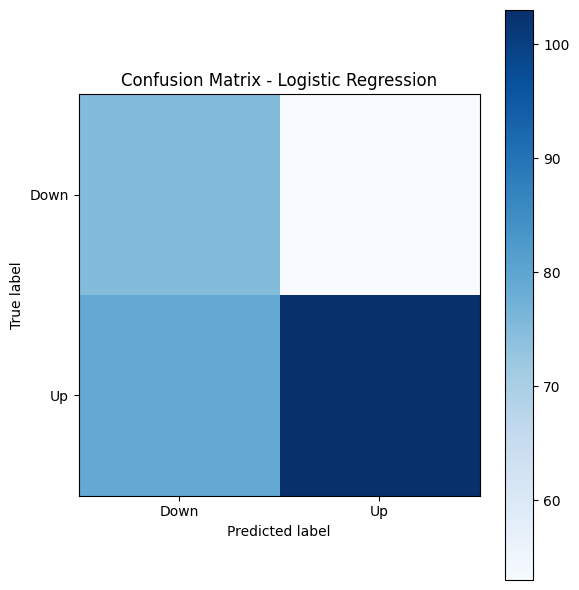

<Figure size 1000x600 with 0 Axes>

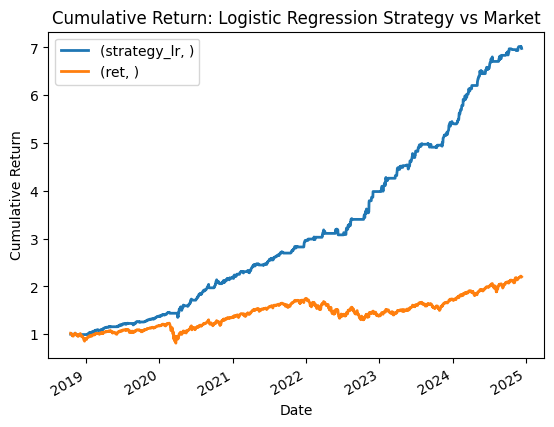

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_percentage_error

# Download S&P 500 data for the past 5 years
sp500 = yf.download('^GSPC', start='2018-01-01')

# Daily Returns: Percent change in closing prices
sp500['ret'] = sp500['Close'].pct_change()

# Moving Averages: 20 periods, 50, 200 periods
def moving_averages(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()  # 20-period moving average
    df['SMA_50'] = df['Close'].rolling(window=50).mean()  # 50-period moving average
    df['SMA_200'] = df['Close'].rolling(window=200).mean()  # 200-period moving average
    return df

sp500 = moving_averages(sp500)

# Bollinger Bands
def bollinger_bands(df):
    df['BB_middle'] = df['Close'].rolling(window=20).mean()  # 20-period moving average
    df['BB_std'] = df['Close'].rolling(window=20).std()  # Standard deviation
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)  # Upper band
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)  # Lower band
    return df

sp500 = bollinger_bands(sp500)

# Relative Strength Index (RSI)
def rsi(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

sp500 = rsi(sp500)

# Lagged Returns
def lagit(df, lags):
    for i in range(1, lags + 1):
        df['Lag_' + str(i)] = df['ret'].shift(i)
    return ['Lag_' + str(i) for i in range(1, lags + 1)]


features = lagit(sp500, 3)

sp500['direction'] = np.where(sp500['ret'] > 0, 1, 0)

sp500.dropna(inplace=True)

X = sp500[features + ['SMA_20', 'SMA_50', 'SMA_200', 'BB_upper', 'BB_lower', 'RSI']]
Y = sp500['direction']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

model = sklearn.linear_model.LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(Y_test, Y_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(2), ['Down', 'Up'])
plt.yticks(np.arange(2), ['Down', 'Up'])
plt.tight_layout()
plt.show()

# predictions and strategy
sp500['prediction_lr'] = model.predict(X)
sp500['strategy_lr'] = sp500['prediction_lr'] * sp500['ret']

plt.figure(figsize=(10, 6))
(sp500[['strategy_lr', 'ret']] + 1).cumprod().plot(label='Logistic Regression Strategy vs Market', lw=2)
plt.title('Cumulative Return: Logistic Regression Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



Random Forest

[*********************100%***********************]  1 of 1 completed


Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.44      0.50      0.47       128
           1       0.61      0.55      0.58       182

    accuracy                           0.53       310
   macro avg       0.53      0.53      0.53       310
weighted avg       0.54      0.53      0.54       310



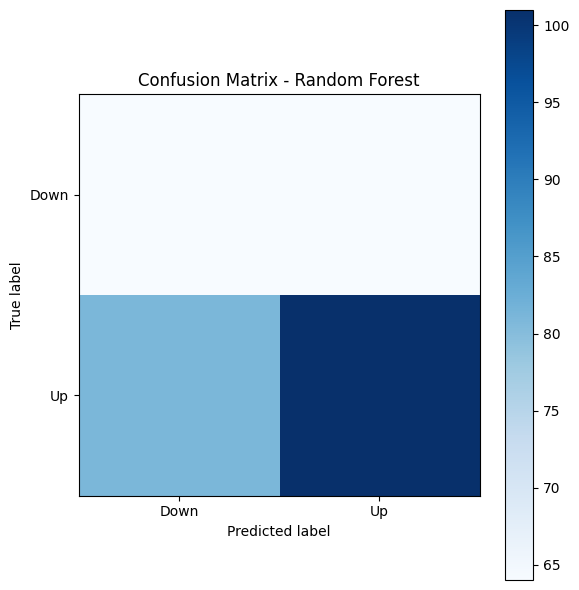

<Figure size 1000x600 with 0 Axes>

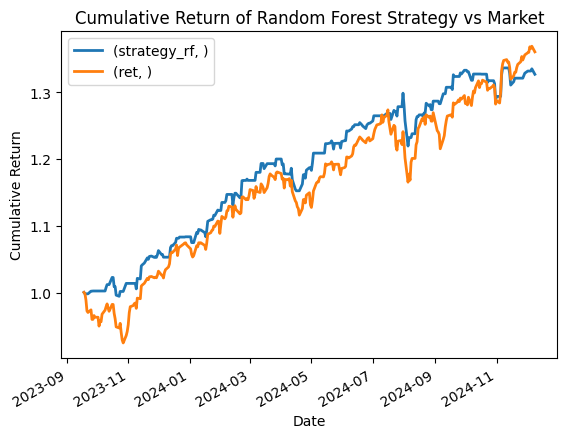

Feature Importance for Random Forest:
        Feature  Importance
8       (RSI, )    0.172770
0     (Lag_1, )    0.130930
1     (Lag_2, )    0.128751
2     (Lag_3, )    0.123353
5   (SMA_200, )    0.093084
7  (BB_lower, )    0.091289
6  (BB_upper, )    0.089500
3    (SMA_20, )    0.086716
4    (SMA_50, )    0.083607
Sharpe Ratio for Random Forest: 2.55


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Download S&P 500 data for the past 5 years
sp500 = yf.download('^GSPC', start='2018-01-01')

# Calculate daily returns
sp500['ret'] = sp500.Close.pct_change()


# Moving Averages
def moving_averages(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()  # 20-period moving average
    df['SMA_50'] = df['Close'].rolling(window=50).mean()  # 50-period moving average
    df['SMA_200'] = df['Close'].rolling(window=200).mean()  # 200-period moving average
    return df

# Bollinger Bands
def bollinger_bands(df):
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)
    return df

# RSI
def rsi(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# Lagged Returns
def lagit(df, lags):
    for i in range(1, lags + 1):
        df[f'Lag_{i}'] = df['ret'].shift(i)
    return [f'Lag_{i}' for i in range(1, lags + 1)]

sp500 = moving_averages(sp500)
sp500 = bollinger_bands(sp500)
sp500 = rsi(sp500)

lag_features = lagit(sp500, 3)

sp500['direction'] = np.where(sp500['ret'] > 0, 1, 0)

sp500.dropna(inplace=True)

X = sp500[lag_features + ['SMA_20', 'SMA_50', 'SMA_200', 'BB_upper', 'BB_lower', 'RSI']]
Y = sp500['direction']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, Y_train)

Y_pred_rf = model_rf.predict(X_test)

print("Random Forest Model Evaluation:")
print(classification_report(Y_test, Y_pred_rf))

cm_rf = confusion_matrix(Y_test, Y_pred_rf)
plt.figure(figsize=(6, 6))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(2), ['Down', 'Up'])
plt.yticks(np.arange(2), ['Down', 'Up'])
plt.tight_layout()
plt.show()

X_test['prediction_rf'] = Y_pred_rf
X_test['ret'] = sp500.loc[X_test.index, 'ret']
X_test['strategy_rf'] = X_test['prediction_rf'] * X_test['ret']

plt.figure(figsize=(10, 6))
(X_test[['strategy_rf', 'ret']] + 1).cumprod().plot(label='Random Forest Strategy vs Market', lw=2)
plt.title('Cumulative Return of Random Forest Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance for Random Forest:")
print(feature_importances)

def calculate_sharpe_ratio(strategy_returns):
    return np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)  # Annualized Sharpe Ratio

sharpe_ratio_rf = calculate_sharpe_ratio(X_test['strategy_rf'])
print(f"Sharpe Ratio for Random Forest: {sharpe_ratio_rf:.2f}")


Ensemble

PCA explained variance ratio: [9.68153554e-01 2.55521339e-02 4.48010234e-03 1.69737803e-03
 1.16831458e-04]
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.56      0.50       128
           1       0.63      0.53      0.57       182

    accuracy                           0.54       310
   macro avg       0.54      0.54      0.54       310
weighted avg       0.56      0.54      0.55       310

Random Forest Sharpe Ratio: 3.68
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.16      0.26       128
           1       0.61      0.92      0.74       182

    accuracy                           0.61       310
   macro avg       0.61      0.54      0.50       310
weighted avg       0.61      0.61      0.54       310

Grad

<Figure size 1000x600 with 0 Axes>

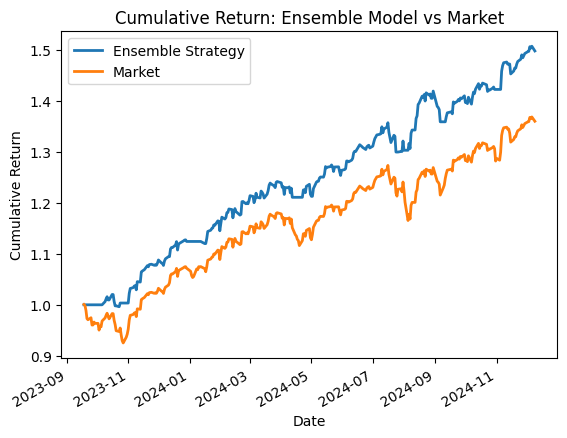

In [12]:
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA

def hyperparameter_tuning_rf(X_train, Y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring='accuracy',
        cv=TimeSeriesSplit(n_splits=5),
        n_jobs=-1
    )
    grid_search.fit(X_train, Y_train)
    print("Best Parameters for Random Forest:", grid_search.best_params_)
    return grid_search.best_estimator_

features = lag_features + ['SMA_20', 'SMA_50', 'SMA_200', 'BB_upper', 'BB_lower', 'RSI']
X = sp500[features]
Y = sp500['direction']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)


# PCA
def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    return X_train_pca, X_test_pca

X_train_pca, X_test_pca = apply_pca(X_train, X_test)

rf_model = hyperparameter_tuning_rf(X_train_pca, Y_train)
Y_pred_rf = rf_model.predict(X_test_pca)

# Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train_pca, Y_train)
Y_pred_gbm = gbm_model.predict(X_test_pca)

# Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('log_reg', model),  # Logistic Regression
        ('rf', rf_model),    # Random Forest
        ('gbm', gbm_model)   # Gradient Boosting
    ],
    voting='soft'
)
ensemble_model.fit(X_train_pca, Y_train)
Y_pred_ensemble = ensemble_model.predict(X_test_pca)

def evaluate_model(Y_true, Y_pred, model_name):
    print(f"{model_name} Classification Report:")
    print(classification_report(Y_true, Y_pred))

    temp_df = pd.DataFrame({'prediction': Y_pred, 'ret': sp500.loc[X_test.index, 'ret']}, index=X_test.index)
    temp_df['strategy'] = temp_df['prediction'] * temp_df['ret']
    sharpe_ratio = calculate_sharpe_ratio(temp_df['strategy'])
    print(f"{model_name} Sharpe Ratio: {sharpe_ratio:.2f}")

evaluate_model(Y_test, Y_pred_rf, "Random Forest")
evaluate_model(Y_test, Y_pred_gbm, "Gradient Boosting")
evaluate_model(Y_test, Y_pred_ensemble, "Ensemble")

# Backtesting Plot
temp_df = pd.DataFrame({'prediction': Y_pred_ensemble, 'ret': sp500.loc[X_test.index, 'ret']}, index=X_test.index)
temp_df['strategy_ensemble'] = temp_df['prediction'] * temp_df['ret']
plt.figure(figsize=(10, 6))
(temp_df[['strategy_ensemble', 'ret']] + 1).cumprod().plot(lw=2)
plt.title('Cumulative Return: Ensemble Model vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(['Ensemble Strategy', 'Market'])
plt.show()
